In [62]:
import numpy as np
import pandas as pd
import glob
import random

# image
from PIL import Image

# visu
import matplotlib.pyplot as plt

# sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#tensorflow
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import load_model

In [63]:
TUTORIAL = True

In [64]:
filelist = glob.glob("./input/valid/*")
s = [fname.split("\\")[-1] for fname in filelist]
species = []
for spec in s:
    #print(spec)
    if TUTORIAL and spec in ["ANTBIRD", "BLACK SWAN", "BLUE HERON"]:
        #species.append(spec)
        pass
species = s[:30]

labelCount = len(species)
print(f"레이블 개수: {len(species)}")
print(species)

레이블 개수: 30
['ABBOTTS BABBLER', 'ABBOTTS BOOBY', 'ABYSSINIAN GROUND HORNBILL', 'AFRICAN CROWNED CRANE', 'AFRICAN EMERALD CUCKOO', 'AFRICAN FIREFINCH', 'AFRICAN OYSTER CATCHER', 'ALBATROSS', 'ALBERTS TOWHEE', 'ALEXANDRINE PARAKEET', 'ALPINE CHOUGH', 'ALTAMIRA YELLOWTHROAT', 'AMERICAN AVOCET', 'AMERICAN BITTERN', 'AMERICAN COOT', 'AMERICAN GOLDFINCH', 'AMERICAN KESTREL', 'AMERICAN PIPIT', 'AMERICAN REDSTART', 'AMETHYST WOODSTAR', 'ANDEAN GOOSE', 'ANDEAN LAPWING', 'ANDEAN SISKIN', 'ANHINGA', 'ANIANIAU', 'ANNAS HUMMINGBIRD', 'ANTBIRD', 'ANTILLEAN EUPHONIA', 'APAPANE', 'APOSTLEBIRD']


In [65]:
datasets = ["train", "test", "valid"]

im_width = round(224)
im_height = round(224)
print("Image new width: " + str(im_width))
print("Image new height: " + str(im_height))

Image new width: 56
Image new height: 56


In [66]:
%%time

data = dict({"train": [], "test": [], "valid": []})
target = dict({"train": [], "test": [], "valid": []})

for set_ in datasets:
    for spec in species:
        filelist = glob.glob('./input/' + set_ + '/' + spec + '/*.jpg')
        target[set_].extend([spec for _ in filelist])
        data[set_].extend([np.array(Image.open(fname).resize((im_width, im_height))) for fname in filelist])
    data[set_] = np.stack(data[set_], axis=0)

Wall time: 4.63 s


In [67]:
print("train set shape: " + str(data["train"].shape))
print("test set shape: " + str(data["test"].shape))
print("validation set shape: " + str(data["valid"].shape))

train set shape: (4501, 56, 56, 3)
test set shape: (150, 56, 56, 3)
validation set shape: (150, 56, 56, 3)


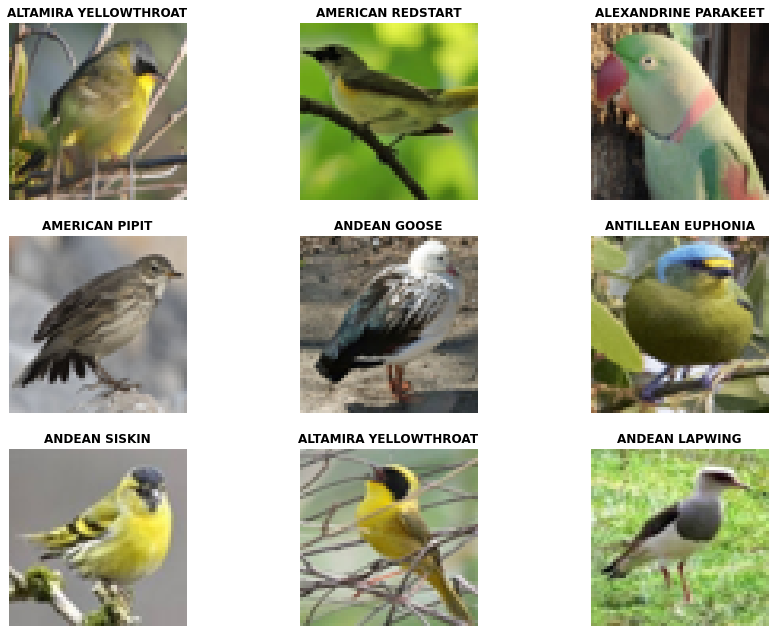

In [68]:
fig = plt.figure(figsize=(20,15))
gs = fig.add_gridspec(4, 4)
#
for row in range(0, 3):
    for col in range(0, 3):
        num_image = random.randint(0, data["train"].shape[0])
        ax = fig.add_subplot(gs[row, col])
        ax.axis('off');
        ax.set_title(target["train"][num_image], fontdict={"fontweight": 700})
        ax.imshow(data["train"][num_image]);

In [69]:
print(data["train"].max())
print(data["train"].min())

255
0


In [70]:
data_norm = data.copy()

In [71]:
data_norm["train"] = np.round((data_norm["train"]/255), 3)
data_norm["test"] = np.round((data_norm["test"]/255), 3)
data_norm["valid"] = np.round((data_norm["valid"]/255), 3)

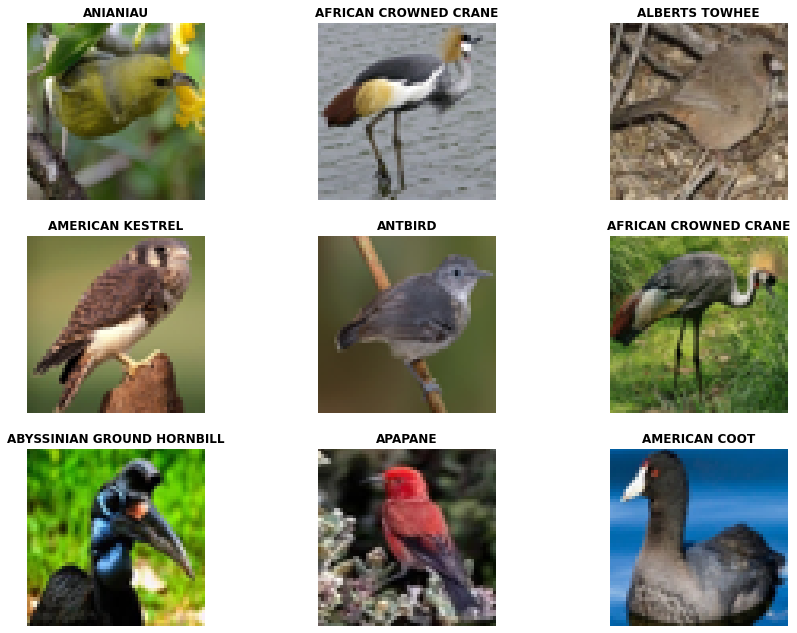

In [72]:
fig = plt.figure(figsize=(20,15))
gs = fig.add_gridspec(4, 4)
#
for row in range(0, 3):
    for col in range(0, 3):
        num_image = random.randint(0, data_norm["train"].shape[0])
        ax = fig.add_subplot(gs[row, col])
        ax.axis('off');
        ax.set_title(target["train"][num_image], fontdict={"fontweight": 700})
        ax.imshow(data_norm["train"][num_image]);

In [73]:
encoder = LabelEncoder().fit(target["test"])

In [74]:
target_cat = target.copy()

In [75]:
target_cat["train"] = encoder.transform(target_cat["train"])
for label in np.unique(target_cat["test"]):
    if label not in encoder.classes_: # unseen label 데이터인 경우( )
        encoder.classes_ = np.append(encoder.classes_, label) # 미처리 시 ValueError발생
target_cat["test"]  = encoder.transform(target_cat["test"])
target_cat["valid"] = encoder.transform(target_cat["valid"])

In [76]:
target_ohe = target_cat.copy()

In [77]:
target_ohe["train"] = to_categorical(target_ohe["train"])
target_ohe["test"] = to_categorical(target_ohe["test"])
target_ohe["valid"] = to_categorical(target_ohe["valid"])

In [78]:
pd.DataFrame(target_ohe["test"]).head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [79]:
def initialize_model(name):
    model = Sequential(name=name)
    model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(im_height, im_width, 3), padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation="relu", padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation="relu", padding='same'))
    model.add(layers.MaxPool2D(pool_size=(3, 3)))
    model.add(layers.Flatten())
    model.add(layers.Dense(120, activation='relu'))
    model.add(layers.Dense(60, activation='relu'))
    model.add(layers.Dropout(rate=0.2))
    model.add(layers.Dense(labelCount, activation='softmax'))

    return model

In [80]:
model = initialize_model(name="baseline")
model.summary()

Model: "baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 56, 56, 32)        896       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 2048)              0  

In [81]:
def compile_model(model):
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics="accuracy")
    return model

In [82]:
print(data_norm["train"].shape)
print(target_ohe["train"].shape)
print(data_norm["valid"].shape)
print(target_ohe["valid"].shape)

(4501, 56, 56, 3)
(4501, 30)
(150, 56, 56, 3)
(150, 30)


In [83]:
model_baseline = initialize_model(name="baseline")
model_baseline = compile_model(model_baseline)
#
callback = [EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True), ReduceLROnPlateau(monitor = 'val_loss', patience = 1, factor=0.5, verbose=1)]
#
history_baseline = model_baseline.fit(data_norm["train"], target_ohe["train"],
                                      batch_size=16,
                                      epochs=100,
                                      validation_data=(data_norm["valid"], target_ohe["valid"]),
                                      callbacks=callback)



Epoch 1/100
282/282 [==============================] - 2s 5ms/step - loss: 3.1123 - accuracy: 0.1095 - val_loss: 2.4985 - val_accuracy: 0.2467
Epoch 2/100
282/282 [==============================] - 1s 3ms/step - loss: 2.3787 - accuracy: 0.2857 - val_loss: 1.8953 - val_accuracy: 0.3933
Epoch 3/100
282/282 [==============================] - 1s 3ms/step - loss: 1.9683 - accuracy: 0.3981 - val_loss: 1.5424 - val_accuracy: 0.5533
Epoch 4/100
282/282 [==============================] - 1s 3ms/step - loss: 1.6336 - accuracy: 0.4912 - val_loss: 1.4654 - val_accuracy: 0.5600
Epoch 5/100
282/282 [==============================] - 1s 4ms/step - loss: 1.4351 - accuracy: 0.5588 - val_loss: 1.1953 - val_accuracy: 0.6200
Epoch 6/100
282/282 [==============================] - 1s 4ms/step - loss: 1.2522 - accuracy: 0.6034 - val_loss: 1.2516 - val_accuracy: 0.6133

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/100
282/282 [==============================] - 1s 4ms

In [84]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

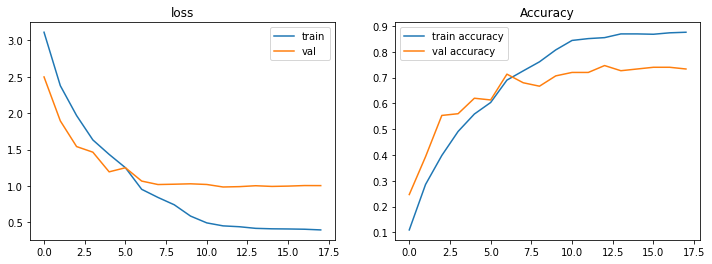

In [85]:
plot_history(history_baseline, title='', axs=None, exp_name="");


In [86]:
model_baseline.evaluate(data_norm["test"], target_ohe["test"], verbose=0)

[0.6889383792877197, 0.8133333325386047]

In [87]:
y_pred = [np.argmax(val) for val in list(model_baseline.predict(data_norm["test"]))]
y_true = target_cat["test"].copy()

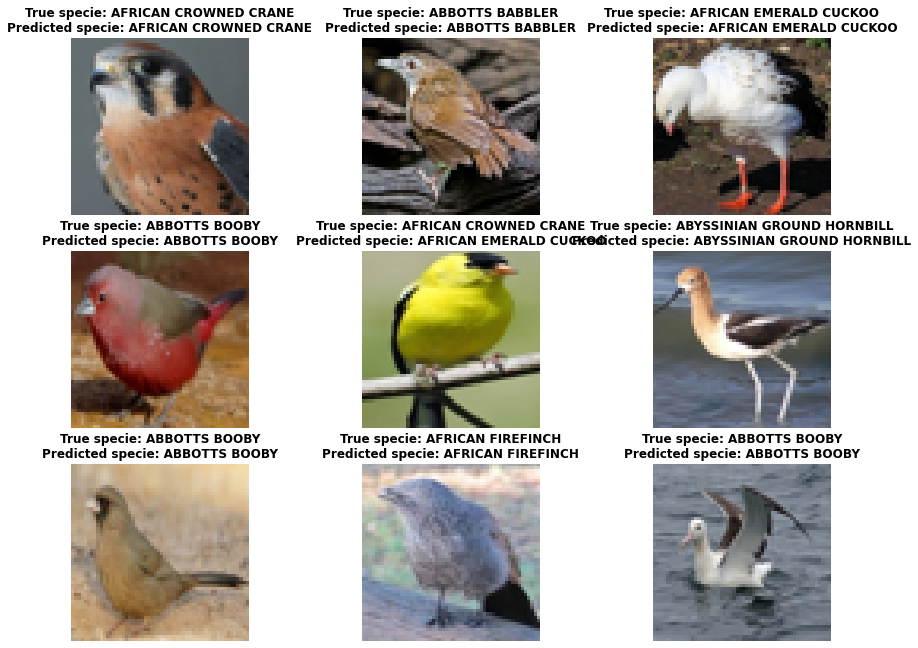

In [88]:
fig = plt.figure(figsize=(20,15))
gs = fig.add_gridspec(4, 4)
#
for row in range(0, 3):
    for col in range(0, 3):
        num_image = random.randint(0, data_norm["test"].shape[0])
        ax = fig.add_subplot(gs[row, col])
        ax.axis('off');
        ax.set_title("True specie: " + str(target["test"][y_true[num_image]] + "\nPredicted specie: " + target["test"][y_pred[num_image]]), fontdict={"fontweight": 700})
        ax.imshow(data["test"][num_image]);

# 증강

In [113]:
model_VGG = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
model_VGG.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 56, 56, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 56, 56, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 56, 56, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 28, 28, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 28, 28, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 28, 28, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 14, 14, 128)       0     

In [114]:
model_VGG.trainable = False
model_VGG.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 56, 56, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 56, 56, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 56, 56, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 28, 28, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 28, 28, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 28, 28, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 14, 14, 128)       0     

In [115]:
flattening_layer = layers.Flatten()
dropout = layers.Dropout(rate=0.4)
norm = layers.BatchNormalization()
last_layer = layers.Dense(400, activation='softmax')

model_VGG = Sequential([model_VGG, flattening_layer, dropout, norm, last_layer])

model_VGG.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_10 (Flatten)         (None, 512)               0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_26 (Dense)             (None, 400)               205200    
Total params: 14,921,936
Trainable params: 206,224
Non-trainable params: 14,715,712
_________________________________________________________________


In [125]:
model_VGG.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics="accuracy")
datagen_vgg = ImageDataGenerator(preprocessing_function=preprocess_input,
                                 zoom_range=(0.8, 1.2))
#
train_generator_vgg = datagen_vgg.flow_from_directory('./input/train',
                                                      batch_size=64,
                                                      target_size=(224,224),
                                                      class_mode='categorical')
validation_generator_vgg = datagen_vgg.flow_from_directory('./input/test',
                                                           batch_size=64,
                                                           target_size=(224,224),
                                                           class_mode='categorical')
fig = plt.figure(figsize=(20,15))
gs = fig.add_gridspec(4, 4)
#
for row in range(0, 3):
    for col in range(0, 3):
        image, label = train_generator_vgg.next()
        label_id = list(label[0]).index(1)
        label_str = list(train_generator_vgg.class_indices.keys())[list(train_generator_vgg.class_indices.values()).index(label_id)]
        ax = fig.add_subplot(gs[row, col])
        ax.axis('off');
        ax.set_title(label_str, fontdict={"fontweight": 700})
        ax.imshow(image[0]);

Found 58388 images belonging to 400 classes.
Found 2000 images belonging to 400 classes.


In [127]:

callback = [EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True),
            ReduceLROnPlateau(monitor = 'val_loss', patience = 1, factor=0.5, verbose=1)]

history_VGG = model_VGG.fit(train_generator_vgg,
                            epochs=100,
                            validation_data=validation_generator_vgg,
                            callbacks=callback)

Epoch 1/100
913/913 [==============================] - 70s 76ms/step - loss: 3.3768 - accuracy: 0.2797 - val_loss: 2.4567 - val_accuracy: 0.4610
Epoch 2/100
913/913 [==============================] - 64s 70ms/step - loss: 3.1152 - accuracy: 0.3193 - val_loss: 2.3066 - val_accuracy: 0.4825
Epoch 3/100
913/913 [==============================] - 54s 59ms/step - loss: 3.0100 - accuracy: 0.3352 - val_loss: 2.1978 - val_accuracy: 0.5110
Epoch 4/100
913/913 [==============================] - 56s 61ms/step - loss: 2.9423 - accuracy: 0.3449 - val_loss: 2.1649 - val_accuracy: 0.5155
Epoch 5/100
913/913 [==============================] - 54s 59ms/step - loss: 2.9002 - accuracy: 0.3482 - val_loss: 2.0991 - val_accuracy: 0.5225
Epoch 6/100
913/913 [==============================] - 54s 59ms/step - loss: 2.8716 - accuracy: 0.3547 - val_loss: 2.1166 - val_accuracy: 0.5195

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/100
913/913 [============================

In [ ]:
model_VGG.save("model_VGG.h5")